**Clone repository and download models**

In [1]:
# Clone the repository
!git clone https://github.com/richarduuz/Research_Project

Cloning into 'Research_Project'...
remote: Enumerating objects: 418, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 418 (delta 4), reused 2 (delta 0), pack-reused 409 (from 1)
Receiving objects: 100% (418/418), 43.76 MiB | 39.93 MiB/s, done.
Resolving deltas: 100% (142/142), done.


In [2]:
# Navigate and download additional files
%cd /kaggle/working/Research_Project/ModelC/face_modules/
!gdown https://drive.google.com/uc?id=15nZSJ2bAT3m-iCBqP3N_9gld5_EGv4kp

%cd /kaggle/working/Research_Project/ModelC/saved_models/
!gdown https://drive.google.com/uc?id=1iANX7oJoXCEECNzBEW1xOpac2tDOKeu9

/kaggle/working/Research_Project/ModelC/face_modules
Downloading...
From (original): https://drive.google.com/uc?id=15nZSJ2bAT3m-iCBqP3N_9gld5_EGv4kp
From (redirected): https://drive.google.com/uc?id=15nZSJ2bAT3m-iCBqP3N_9gld5_EGv4kp&confirm=t&uuid=0aed1f92-0955-40e6-97f3-6718ddf3265e
To: /kaggle/working/Research_Project/ModelC/face_modules/model_ir_se50.pth
100%|████████████████████████████████████████| 175M/175M [00:01<00:00, 89.8MB/s]
/kaggle/working/Research_Project/ModelC/saved_models
Downloading...
From (original): https://drive.google.com/uc?id=1iANX7oJoXCEECNzBEW1xOpac2tDOKeu9
From (redirected): https://drive.google.com/uc?id=1iANX7oJoXCEECNzBEW1xOpac2tDOKeu9&confirm=t&uuid=f7083388-8b34-4674-ab8d-ec1415f4130c
To: /kaggle/working/Research_Project/ModelC/saved_models/G_latest.pth
100%|████████████████████████████████████████| 737M/737M [00:07<00:00, 99.4MB/s]


In [3]:
!pip install -r /kaggle/working/Research_Project/ModelC/requirements.txt

**Load model**

In [4]:
%cd /kaggle/working/Research_Project/ModelC/

/kaggle/working/Research_Project/ModelC


In [5]:
import sys
import torch
sys.path.append('/kaggle/working/Research_Project/ModelC/face_modules/')
print(sys.path)
import torchvision.transforms as transforms
import torch.nn.functional as F
from face_modules.model import Backbone, Arcface, MobileFaceNet, Am_softmax, l2_norm
from network.AEI_Net import *
from face_modules.mtcnn import *
import cv2
import PIL.Image as Image
import numpy as np
import configparser

['/kaggle/working', '/kaggle/lib/kagglegym', '/kaggle/lib', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/usr/local/lib/python3.10/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.10/dist-packages/IPython/extensions', '/usr/local/lib/python3.10/dist-packages/setuptools/_vendor', '/root/.ipython', '/kaggle/working/Research_Project/ModelC/face_modules/']


/kaggle/working/Research_Project/ModelC/face_modules/mtcnn_pytorch/src/align_trans.py:289: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if align_type is 'cv2_affine':
/kaggle/working/Research_Project/ModelC/face_modules/mtcnn_pytorch/src/align_trans.py:292: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif align_type is 'affine':


In [6]:
detector = MTCNN()
device = torch.device('cuda')
G = AEI_Net(c_id=512)
G.eval()
G.load_state_dict(torch.load('./saved_models/G_latest.pth', map_location=torch.device('cpu')))
G = G.cuda()

arcface = Backbone(50, 0.6, 'ir_se').to(device)
arcface.eval()
arcface.load_state_dict(torch.load('./face_modules/model_ir_se50.pth', map_location=device), strict=False)

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

<ipython-input-6-cd82b8fb3154>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  G.load_state_dict(torch.load('./saved_models/G_latest.pth', map_location=torch.device('cpu'))

**Image inferences**

Public Kaggle data sets, FFHQ and CelebA are used for source image and target image.

**Test: Check file directory**

In [7]:
#Check file directory
import os
celeba_path = '/kaggle/input/celebahq-resized-256x256/celeba_hq_256'
ffhq_path = '/kaggle/input/ffhq-256x256/images256x256'

print("CelebA files:", "Path Found" if os.path.exists(celeba_path) else "Path not found")
print("FFHQ files:", "Path Found" if os.path.exists(ffhq_path) else "Path not found")

CelebA files: Path Found
FFHQ files: Path Found


**Test: Check if source and target image exist**

In [8]:
import os
import cv2

# Check specific files
celeba_file = '/kaggle/input/celebahq-resized-256x256/celeba_hq_256/00000.jpg'
ffhq_file = '/kaggle/input/ffhq-256x256/images256x256/00000.png'

# Check if files exist
print(f"CelebA file exists: {os.path.exists(celeba_file)}")
print(f"FFHQ file exists: {os.path.exists(ffhq_file)}")

# Try to read the images
if os.path.exists(celeba_file):
    celeba_img = cv2.imread(celeba_file)
    if celeba_img is not None:
        print(f"CelebA image shape: {celeba_img.shape}")
    else:
        print("Failed to read CelebA image")

if os.path.exists(ffhq_file):
    ffhq_img = cv2.imread(ffhq_file)
    if ffhq_img is not None:
        print(f"FFHQ image shape: {ffhq_img.shape}")
    else:
        print("Failed to read FFHQ image")

CelebA file exists: True
FFHQ file exists: True
CelebA image shape: (256, 256, 3)
FFHQ image shape: (256, 256, 3)


**Test: Display source and target image**

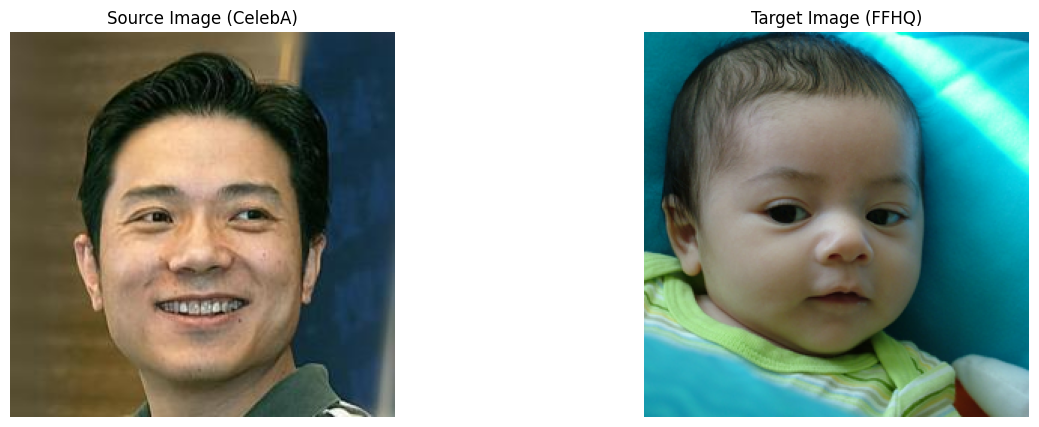

CelebA image shape: (256, 256, 3)
FFHQ image shape: (256, 256, 3)


In [9]:
# Display images

import cv2
import matplotlib.pyplot as plt

# Read images
celeba_file = '/kaggle/input/celebahq-resized-256x256/celeba_hq_256/00000.jpg'
ffhq_file = '/kaggle/input/ffhq-256x256/images256x256/00000.png'

celeba_img = cv2.imread(celeba_file)
ffhq_img = cv2.imread(ffhq_file)

# Create a figure with two subplots side by side
plt.figure(figsize=(15, 5))

# Display CelebA image (source)
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(celeba_img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for correct colors
plt.title('Source Image (CelebA)')
plt.axis('off')

# Display FFHQ image (target)
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(ffhq_img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for correct colors
plt.title('Target Image (FFHQ)')
plt.axis('off')

plt.show()

# Print image shapes
print(f"CelebA image shape: {celeba_img.shape}")
print(f"FFHQ image shape: {ffhq_img.shape}")

**Generate output images**

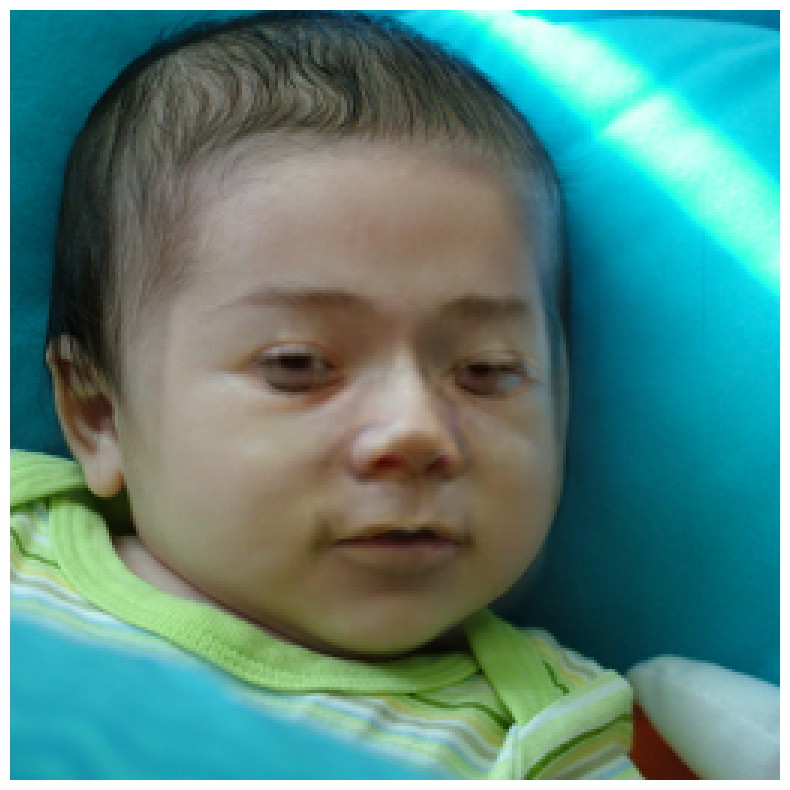

the result image has been saved


In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn.functional as F
import os

# Read source image 
# Used FFHQ dataset as source
#Xs_raw = cv2.imread('/kaggle/input/ffhq-256x256/images256x256/00000.png') 
# Current: Use CelebA dataset as source
Xs_raw = cv2.imread('/kaggle/input/celebahq-resized-256x256/celeba_hq_256/00000.jpg') 
try:
    Xs = detector.align(Image.fromarray(Xs_raw[:, :, ::-1]), crop_size=(256, 256))
except Exception as e:
    print('the source image is wrong, please change the image')
Xs_raw = np.array(Xs)[:, :, ::-1]
Xs = test_transform(Xs)
Xs = Xs.unsqueeze(0).cuda()


with torch.no_grad():
    embeds = arcface(F.interpolate(Xs[:, :, 19:237, 19:237], (112, 112), mode='bilinear', align_corners=True))

# Read target image
# Current: Use FFHQ dataset as target
Xt_raw = cv2.imread('/kaggle/input/ffhq-256x256/images256x256/00000.png') 
# Use CelebA dataset as target
#Xt_raw = cv2.imread('/kaggle/input/celebahq-resized-256x256/celeba_hq_256/00000.jpg') 
try:
    Xt, trans_inv = detector.align(Image.fromarray(Xt_raw[:, :, ::-1]), crop_size=(256, 256), return_trans_inv=True)
except Exception as e:
    print('the target image is wrong, please change the image')
Xt_raw = Xt_raw.astype(float) / 255.0
Xt = test_transform(Xt)
Xt = Xt.unsqueeze(0).cuda()

# Create mask
mask = np.zeros([256, 256], dtype=float)
for i in range(256):
    for j in range(256):
        dist = np.sqrt((i-128)**2 + (j-128)**2)/128
        dist = np.minimum(dist, 1)
        mask[i, j] = 1-dist
mask = cv2.dilate(mask, None, iterations=20)

# Process and generate result
with torch.no_grad():
    Yt, _ = G(Xt, embeds)
    Yt = Yt.squeeze().detach().cpu().numpy().transpose([1, 2, 0])*0.5 + 0.5
    Yt = Yt[:, :, ::-1]
    Yt_trans_inv = cv2.warpAffine(Yt, trans_inv, (np.size(Xt_raw, 1), np.size(Xt_raw, 0)), borderValue=(0, 0, 0))
    mask_ = cv2.warpAffine(mask, trans_inv, (np.size(Xt_raw, 1), np.size(Xt_raw, 0)), borderValue=(0, 0, 0))
    mask_ = np.expand_dims(mask_, 2)
    Yt_trans_inv = mask_*Yt_trans_inv + (1-mask_)*Xt_raw
    
    # Display result using matplotlib instead of cv2_imshow
    Yt_trans_inv = (Yt_trans_inv * 255).astype(np.uint8)
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(Yt_trans_inv, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

    os.makedirs('/kaggle/working/generated-image', exist_ok=True)
    
    # Save result to Kaggle working directory
    cv2.imwrite('/kaggle/working/generated-image/00001.jpg', Yt_trans_inv*255)
    print("the result image has been saved")

**Zip the folder**

In [12]:
!zip -r /kaggle/working/generated_images.zip /kaggle/working/generated-image

  adding: kaggle/working/generated-image/ (stored 0%)
  adding: kaggle/working/generated-image/00001.jpg (deflated 1%)
